# Preparation

**Check CUDA & drivers**

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4070 Ti (UUID: GPU-9f5777bd-76c3-8ae0-d0e4-17b8a642c8ce)


**Dataset's installation**

In [2]:
# datasets_url = {
#     'WaveFake': 'https://zenodo.org/records/5642694/files/generated_audio.zip?download=1',
#     'In_The_wild': 'https://owncloud.fraunhofer.de/index.php/s/JZgXh0JEAF0elxa/download'
# }

# ! pip install --upgrade gdown

# import gdown

# for name, url in datasets_url.items():
#     output = f"{name}.zip"
#     try:
#         print(f'Downloading file: {name}...')
#         gdown.download(url, output)
#         print(f"File {name} downloaded successfully!")
#     except Exception:
#          print("Error downloading the file.")

# Fake AI Speech Detection

## Initialization step

**Import Cell**

In [2]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import librosa as lb
import seaborn as sns

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    confusion_matrix, 
    precision_score, 
    roc_curve
)
from sklearn.model_selection import train_test_split

from scipy.optimize import brentq
from scipy.interpolate import interp1d

import random
import sqlite3
import os
from collections import Counter
from typing import Tuple

from tqdm import tqdm
from IPython.display import Audio
from termcolor import colored

**Hyperparams**

In [3]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
TORCH_DTYPE = torch.float16 if torch.cuda.is_available() else torch.float32

print("Device type:", colored(DEVICE, "green"))
print("Torch type:", colored(TORCH_DTYPE, "green"))

RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

DATASET_DIR = 'Datasets'
WILD_DATASET_DIR = f'{DATASET_DIR}/In_The_wild/release_in_the_wild'

SAMPLE_RATE = 10_000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 256

AUDIO_SIZE = (128, 128)

TEST_SIZE = 0.2

BATCH_SIZE = 1
LR = 1e-3
NUM_EPOCHS = 20
WAVE_FAKE_DATASET_DIR = f'{DATASET_DIR}/WaveFake/generated_audio'

Device type: cuda:0
Torch type: torch.float16


## Preprocessing step

##### Sound util functions

In [4]:
def load_audio(file_path, sample_rate):
    audio, sr = lb.load(file_path, sr=sample_rate)
    return audio, sr

def mel_spectrogram(audio, sample_rate, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS):
    mel_spec = lb.feature.melspectrogram(y=audio, sr=sample_rate, 
                                              n_fft=n_fft, hop_length=hop_length, 
                                              n_mels=n_mels)
    mel_spec_db = lb.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

##### Dataset loading & preprocessing

In [5]:
def preprocess_metadata_wild(df):
    df = df.drop(['speaker'], axis=1)
    df['file'] = df['file'].apply(lambda x: f"{WILD_DATASET_DIR}/{x}")
    df['label'] = df['label'].apply(lambda x: 0 if x == 'spoof' else 1)
    return df

In [6]:
metadata_wild = preprocess_metadata_wild(pd.read_csv(f"{WILD_DATASET_DIR}/meta.csv"))

print(f'Shape of metadata: {metadata_wild.shape}')
metadata_wild.sample(5)

Shape of metadata: (31779, 2)


,file,label
3155,Datasets/In_The_wild/release_in_the_wild/3155.wav,1
9827,Datasets/In_The_wild/release_in_the_wild/9827.wav,1
20571,Datasets/In_The_wild/release_in_the_wild/20571...,0
20084,Datasets/In_The_wild/release_in_the_wild/20084...,0
9143,Datasets/In_The_wild/release_in_the_wild/9143.wav,1


In [7]:
def get_percenage_plot(df):
    percentage = df['label'].value_counts(normalize=True) * 100

    print(f"Data count", colored(df.shape[0], 'green'))
    ax = sns.barplot(x=percentage.index, y=percentage.values, hue=percentage.index, dodge=False)
    plt.ylabel('%')
    plt.xlabel('Class name')
    plt.xticks(ticks=[0, 1], labels=["AI", "Human"])

    for p in ax.patches:
        if p.get_height() == 0: continue
        ax.annotate(text=f'{p.get_height():.2f}%', 
                    xy=(p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', 
                    fontsize=11, color='black', 
                    xytext=(0, 5),
                    textcoords='offset points')

    plt.title('Percentage Distribution of AI and Human Labels')
    plt.legend().remove()
    plt.show()

Data count 31779


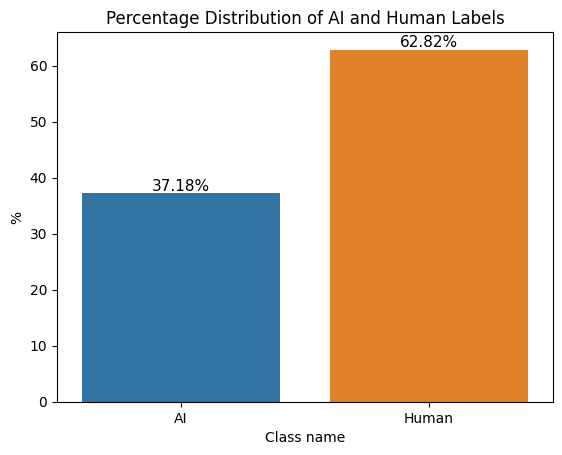

In [8]:
get_percenage_plot(metadata_wild)

Data count 39919


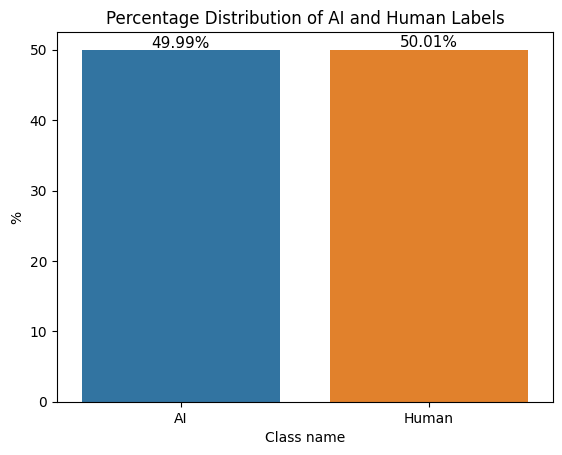

In [10]:
all_counts = Counter(list(metadata_wild['label']))
WAVE_FAKE_DATA_COUNT = all_counts[1] - all_counts[0]
datasets_dirs = os.listdir(WAVE_FAKE_DATASET_DIR)

data_count_per_set = WAVE_FAKE_DATA_COUNT // len(datasets_dirs)
list_of_data_dirs = list()

for data_dir_name in datasets_dirs:
    new_dir = f"{WAVE_FAKE_DATASET_DIR}/{data_dir_name}"
    new_dataset_dir_list = os.listdir(new_dir)
    list_of_data_dirs.extend([f"{new_dir}/{f}" 
                              for f in random.choices(new_dataset_dir_list, k=data_count_per_set)])

extended_metadata = pd.DataFrame({'file': list_of_data_dirs, 'label': [0] * len(list_of_data_dirs)})

merged_metadata = pd.concat([metadata_wild, extended_metadata], ignore_index=True)

get_percenage_plot(merged_metadata)

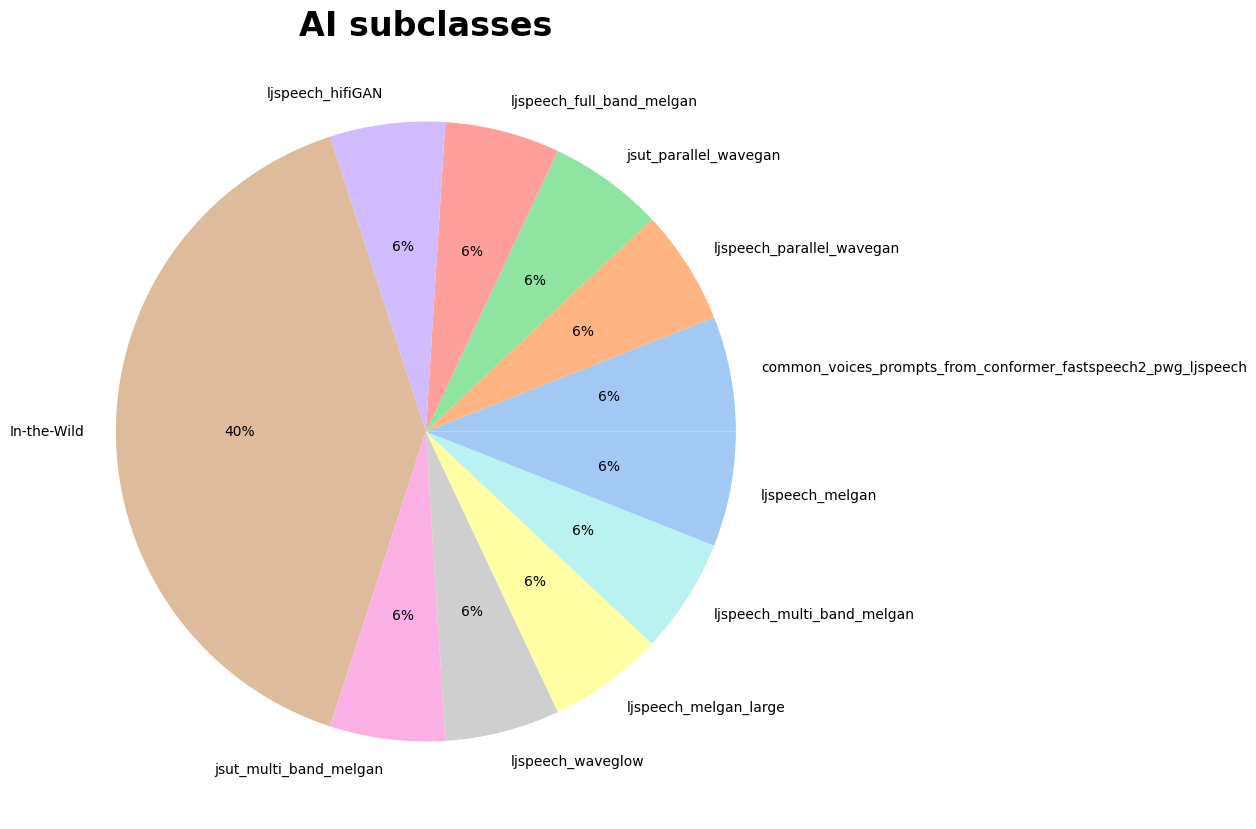

In [10]:
data_perc = [6, 6, 6, 6, 6, 40, 6, 6, 6, 6, 6]
label_perc = datasets_dirs.copy()
label_perc.insert(data_perc.index(40), 'In-the-Wild')
colors = sns.color_palette('pastel')[0:11]

plt.figure(figsize=(10, 16))
plt.title('AI subclasses', weight='bold', size=24)
plt.pie(data_perc, labels = label_perc, colors = colors, autopct='%.0f%%')
plt.show()

##### Proccessor & Dataset classes

In [9]:
class AudioProcessor:
    """
    Processes audio files into mel spectrograms.

    Args:
        sample_rate (int): The sampling rate of the audio files.
        size (int): Desired size of the output mel spectrogram.
    """

    def __init__(self, sample_rate: int, size: int):
        self.sample_rate = sample_rate
        self.size = size

    def __call__(self, file_path: str) -> torch.Tensor:
        """
        Processes an audio file into a mel spectrogram tensor.

        Args:
            file_path (str): Path to the audio file.

        Returns:
            torch.Tensor: Mel spectrogram tensor.
        """
        y, sr = load_audio(file_path, sample_rate=self.sample_rate)
        mel_spec = mel_spectrogram(y, sr)
        
        mel_spec_tensor = torch.tensor(mel_spec[np.newaxis, np.newaxis, ...], dtype=torch.float32)
        mel_spec_tensor = mel_spec_tensor.squeeze(0)
        mel_spec_tensor = mel_spec_tensor.unsqueeze(0)
        mel_spec_tensor = F.interpolate(mel_spec_tensor, size=self.size)
        
        return mel_spec_tensor

class AudioDataset(Dataset):
    """
    Dataset class for loading audio data with corresponding labels.

    Args:
        metadata (DataFrame): Metadata containing file paths and labels.
        transform (callable, optional): Optional transform to be applied to the audio data.
    """

    def __init__(self, metadata, transform):
        self.metadata = metadata
        self.transform = transform
        self.data = []
        self.labels = []
        
        self.load_data()

    def load_data(self):
        """
        Loads audio data and corresponding labels from metadata.
        """
        for idx in tqdm(range(len(self.metadata))):
            file_path = self.metadata.iloc[idx]['file']
            label = self.metadata.iloc[idx]['label']
            
            mel_spec_tensor = self.transform(file_path)
            
            self.data.append(mel_spec_tensor)
            self.labels.append(label)

    def __len__(self) -> int:
        """
        Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Retrieves a sample from the dataset.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: Tuple containing the mel spectrogram tensor and its label.
        """
        mel_spec_tensor = self.data[idx]
        label = self.labels[idx]
        
        return mel_spec_tensor, label
    
    def play_random_audio(self):
        """
        Plays a random audio sample from the dataset.
        """
        idx = random.randint(0, len(self.data) - 1)
        file_path = self.metadata.iloc[idx]['file']
        label = self.metadata.iloc[idx]['label']
        
        y, sr = load_audio(file_path, sample_rate=SAMPLE_RATE)
        display(Audio(data=y, rate=sr))
        
        print(f"Label: {'Fake' if label == 0 else 'True'}")

##### Load & prepare data

In [10]:
train_metadata, test_metadata = train_test_split(merged_metadata, test_size=TEST_SIZE, random_state=RANDOM_SEED)

audio_processor = AudioProcessor(sample_rate=SAMPLE_RATE, size=AUDIO_SIZE)
transform = transforms.Compose([audio_processor])

test_dataset = AudioDataset(test_metadata, transform=transform)
print(colored(f"Test dataset was loaded!", 'green'))
train_dataset = AudioDataset(train_metadata, transform=transform)
print(colored(f"Train dataset was loaded!", 'green'))

100%|██████████| 6356/6356 [03:11<00:00, 33.20it/s]

Test dataset was loaded!


In [13]:
train_dataset.play_random_audio()

Label: Fake


In [15]:
print("Length of train data:", colored(len(train_dataset), "green"))
print("Length of test data:", colored(len(test_dataset), "green"))

Length of train data: 31935
Length of test data: 7984


##### Model Class

In [11]:
class ResidualBlock(nn.Module):
    """
    Implements a residual block.
    
    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        stride (int, optional): Stride value for the first convolutional layer. Default is 1.
    """

    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super(ResidualBlock, self).__init__()
        
        # First convolutional layer with batch normalization
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer with batch normalization
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection to match dimensions if needed
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the residual block.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        out = F.relu(self.bn1(self.conv1(x)))  # First convolution followed by ReLU activation and batch normalization
        out = self.bn2(self.conv2(out))        # Second convolution followed by batch normalization
        out += self.shortcut(x)                # Add shortcut connection
        out = F.relu(out)                      # Apply ReLU activation
        return out

class NeuroMelNet(nn.Module):
    """
    Implements the NeuroMelNet model for classification.
    
    Args:
        num_classes (int, optional): Number of classes. Default is 2.
    """

    def __init__(self, num_classes: int = 2):
        super(NeuroMelNet, self).__init__()
        
        # Initial convolutional layer with ReLU activation
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        
        # Residual blocks
        self.block1 = ResidualBlock(32, 64)
        self.block2 = ResidualBlock(64, 128)

        self.dropout1 = nn.Dropout2d(p=0.25)
        self.dropout2 = nn.Dropout(p=0.5)
        
        # GRU layer for sequential processing
        self.gru = nn.GRU(input_size=128, hidden_size=128, num_layers=1, batch_first=True)
        
        # Fully connected layers for classification
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the NeuroMelNet model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor.
        """
        # Add singleton dimensions to input tensor for compatibility with convolutional layers
        x = x.unsqueeze(0)
        x = x.unsqueeze(1)
        
        # Initial convolution followed by batch normalization and ReLU activation
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)  # Max pooling
        x = self.dropout1(x)  # Dropout
        
        # Residual blocks
        x = self.block1(x)
        x = self.block2(x)
        
        # Global average pooling
        x = x.mean([2, 3])
        
        # Reshape for input to GRU layer
        x = x.view(x.size(0), 1, 128)
        
        # GRU layer
        x, _ = self.gru(x)
        
        # Extract last hidden state
        x = x[:, -1, :]
        
        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        
        # Sigmoid activation for binary classification
        x = F.sigmoid(x)
        
        return x

##### Preparation for training

In [17]:
criterion = nn.BCELoss()
net = NeuroMelNet().to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=LR)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

total_params = sum(p.numel() for p in net.parameters())
print("Total parameters:", colored(total_params, 'green'))

Total parameters: 420866


## Training step

Epoch [1/20]: 100%|██████████| 31935/31935 [01:43<00:00, 309.30it/s]


Epoch [1/20], Train Loss: 0.1487



Epoch [2/20]: 100%|██████████| 31935/31935 [01:43<00:00, 307.94it/s]


Epoch [2/20], Train Loss: 0.0554



Epoch [3/20]: 100%|██████████| 31935/31935 [01:40<00:00, 317.08it/s]


Epoch [3/20], Train Loss: 0.0437



Epoch [4/20]: 100%|██████████| 31935/31935 [01:44<00:00, 306.10it/s]


Epoch [4/20], Train Loss: 0.0342



Epoch [5/20]: 100%|██████████| 31935/31935 [01:40<00:00, 316.31it/s]


Epoch [5/20], Train Loss: 0.0295



Epoch [6/20]: 100%|██████████| 31935/31935 [01:37<00:00, 326.87it/s]


Epoch [6/20], Train Loss: 0.0269



Epoch [7/20]: 100%|██████████| 31935/31935 [01:41<00:00, 314.13it/s]


Epoch [7/20], Train Loss: 0.0220



Epoch [8/20]: 100%|██████████| 31935/31935 [01:51<00:00, 285.77it/s]


Epoch [8/20], Train Loss: 0.0194



Epoch [9/20]: 100%|██████████| 31935/31935 [01:48<00:00, 295.42it/s]


Epoch [9/20], Train Loss: 0.0159



Epoch [10/20]: 100%|██████████| 31935/31935 [01:55<00:00, 277.10it/s]


Epoch [10/20], Train Loss: 0.0152



Epoch [11/20]: 100%|██████████| 31935/31935 [02:37<00:00, 203.02it/s]


Epoch [11/20], Train Loss: 0.0144



Epoch [12/20]: 100%|██████████| 31935/31935 [02:28<00:00, 215.22it/s]


Epoch [12/20], Train Loss: 0.0136



Epoch [13/20]: 100%|██████████| 31935/31935 [01:51<00:00, 287.55it/s]


Epoch [13/20], Train Loss: 0.0127



Epoch [14/20]: 100%|██████████| 31935/31935 [02:03<00:00, 259.30it/s]


Epoch [14/20], Train Loss: 0.0121



Epoch [15/20]: 100%|██████████| 31935/31935 [01:44<00:00, 306.32it/s]


Epoch [15/20], Train Loss: 0.0102



Epoch [16/20]: 100%|██████████| 31935/31935 [02:18<00:00, 230.95it/s]


Epoch [16/20], Train Loss: 0.0136



Epoch [17/20]: 100%|██████████| 31935/31935 [02:33<00:00, 207.88it/s]


Epoch [17/20], Train Loss: 0.0147



Epoch [18/20]: 100%|██████████| 31935/31935 [02:05<00:00, 255.31it/s]


Epoch [18/20], Train Loss: 0.0120



Epoch [19/20]: 100%|██████████| 31935/31935 [02:04<00:00, 256.86it/s]


Epoch [19/20], Train Loss: 0.0090



Epoch [20/20]: 100%|██████████| 31935/31935 [02:04<00:00, 255.95it/s]


Epoch [20/20], Train Loss: 0.0118



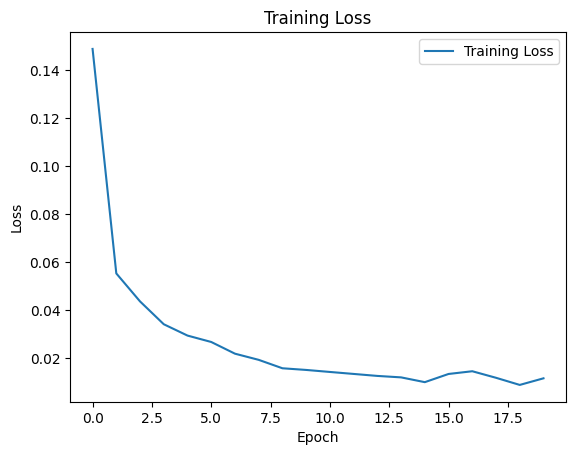

In [24]:
def train_model(model, train_dataloader, optimizer, criterion, num_epochs):
    model.train()
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0.0
        model.train()
        for data, target in tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]"):
            data, target = data.to(DEVICE), target.to(DEVICE)
            
            optimizer.zero_grad()
            
            outputs = model(data.squeeze())
            target = torch.eye(2, device=DEVICE)[target.squeeze()].unsqueeze(0)

            loss = criterion(outputs, target)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        
        output = f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}\n"
        
        print(colored(output, 'cyan'))
    
    return train_losses

train_history = train_model(net, train_dataloader, optimizer, criterion, num_epochs=NUM_EPOCHS)

plt.plot(train_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

**Save & Load utils**

In [12]:
def save_checkpoint(model: nn.Module, optimizer, save_path: str, epoch: int) -> None:
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

def load_checkpoint(load_path: str,  
                    model: nn.Module, 
                    pretrained_eval=False, 
                    optimizer=None):
    checkpoint = torch.load(load_path)
    
    if pretrained_eval:
        model.load_state_dict(checkpoint['model_state_dict'])
        return model
    
    if optimizer is None:
        raise RuntimeError('Optimizer cannot be None')

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']

    return model, optimizer, epoch

In [29]:
save_checkpoint(net, optimizer, f'pretrained/NeuroMelNet.pth', NUM_EPOCHS)

In [13]:
net = NeuroMelNet().to(DEVICE)

net = load_checkpoint(load_path='pretrained/NeuroMelNet.pth', 
                      model=net, 
                      pretrained_eval=True)

## Evaluation Step

#### Util functions

In [14]:
def calculate_metrics(predicted_vals, target_vals):
    accuracy = accuracy_score(target_vals, predicted_vals)
    f1 = f1_score(target_vals, predicted_vals)
    precision = precision_score(target_vals, predicted_vals)
    
    cm = confusion_matrix(target_vals, predicted_vals)

    fpr, tpr, _ = roc_curve(target_vals, predicted_vals, pos_label=1)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    print('EER:', colored(round(eer, 4), 'green'))
    
    print('Accuracy:', colored(round(accuracy, 4), 'green'))
    print('Precision:', colored(round(precision, 4), 'green'))
    print('F1 Score:', colored(round(f1, 4), 'green'))
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['AI', 'Human'], yticklabels=['AI', 'Human'])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


def test_model(model, test_dataset, batch_size=1):
    model.eval()
    
    predictions = []
    targets = []
    
    dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data.squeeze())
            
            predicted = torch.argmax(outputs, dim=1).cpu().numpy()

            predictions.append(predicted.item())
            targets.append(target.item())
        
        calculate_metrics(predictions, targets)

#### Loading human-testing data

In [15]:
cnx = sqlite3.connect('testing.sqlite')
df_db = pd.read_sql_query("SELECT human_answer, true_answer FROM HumanTest", cnx)
cnx.close()

df_db

,human_answer,true_answer
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1101,1,0
1102,0,0
1103,0,0
1104,0,1


#### Evaluation process

Model evaluation:
--------------------
EER: 0.0221
Accuracy: 0.9885
Precision: 0.9864
F1 Score: 0.9908


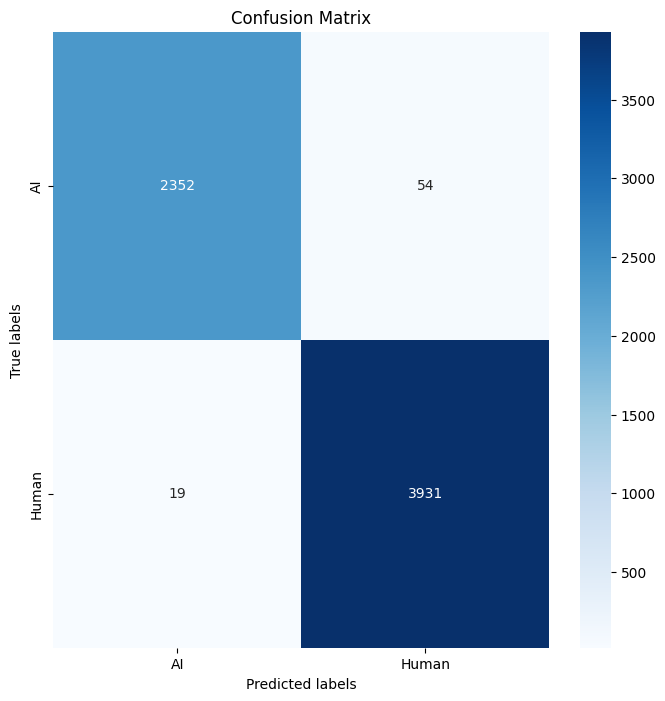

Human evaluation:
--------------------
EER: 0.2573
Accuracy: 0.7631
Precision: 0.8348
F1 Score: 0.8079


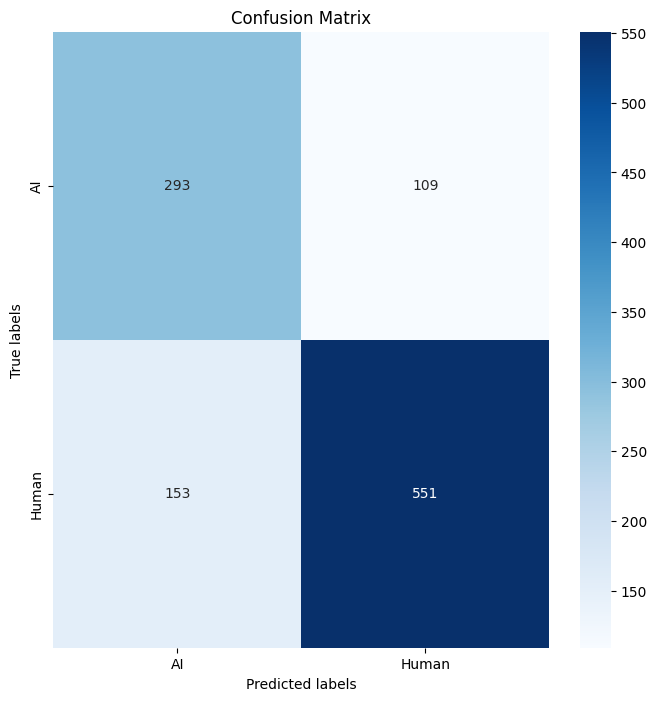

In [16]:
# Model evaluation
print(colored('Model evaluation:\n' + '-' * 20, 'light_magenta'))
test_model(net, test_dataset, batch_size=1)

# Human evaluation
print(colored('Human evaluation:\n' + '-' * 20, 'light_magenta'))
calculate_metrics(list(df_db['human_answer']), df_db['true_answer'])